In [1]:
from utility_functions import get_newest_df, load_bec1serverpath
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd
import multiprocessing as mp
import re
import itertools
import seaborn as sns
# watchfolder = r'Z:\Fermicam 1 data (zcam)\2022\202209\220909\run10_PolaronPAscanUpleg_830nmT3_upleg660mWHPol_50us'
# df = get_newest_df(watchfolder)
# df.keys()
rootfolder = r'Z:\Fermicam 1 data (zcam)\2022\202209'
calibration_file = 'MOT Monitor Calibration Parameter Table'
# plt.rcParams.update({'font.size': 18})

In [2]:
def get_run_dirs(root, selected_dirs = False):
    """
    args: 
        -root: path str of a parent directory. Has to be month or above
        -selected_dirs: list of str where each str is the path to a selected sub diecotry 
        in the parent directory or leave as False to iterate through all
    """
    from glob import glob
    run_dirs = []
    if selected_dirs == False:
        selected_dirs = [dir for dir in os.listdir(root)]
    for dir in selected_dirs:
        path = os.path.abspath(os.path.join(root, dir))
        run_dirs += glob(path + r'/**/run*/', recursive=True)
    return run_dirs    

In [3]:
watchfolders = get_run_dirs(rootfolder,['220913'])

In [4]:

df = pd.concat([get_newest_df(folder) for folder in watchfolders])
df.index = df['run_id']
df.shape

(771, 60)

In [5]:
times = [datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%SZ") for timestamp in df['runtime (format: %Y-%m-%dT%H:%M:%SZ)']]
df['datetimes'] = times
df = df.sort_values(by='datetimes')
df.shape

(771, 61)

In [1]:
NaMOT_ports = [k for k in df.columns if re.search('NaMOT(.*)mean_in_mv',k)]

NameError: name 'df' is not defined

In [7]:
def show_MOT_stat(df):
    mean = df[NaMOT_ports+['Na_TFx']].mean()
    std = df[NaMOT_ports+['Na_TFx']].std()
    percent_drift = 100*std/mean
    port_label = [port.split('_')[1] for port in NaMOT_ports] + ['Na_TFx']
    df_stat = pd.concat([mean,percent_drift],axis=1)
    df_stat.index = port_label
    df_stat.columns = ['Mean PD Voltage [mV]', '% Standard Deviation']
    return df_stat
show_MOT_stat(df)

,Mean PD Voltage [mV],% Standard Deviation
Top,375.047071,18.428279
Bottom,1239.744545,19.927578
KSlowerWindow,305.009006,10.141199
KSlower,1450.404111,10.263890
NaSlowerWindow,3112.089754,11.204271
NaSlower,2851.741342,11.183577
Na_TFx,52.897353,15.189586


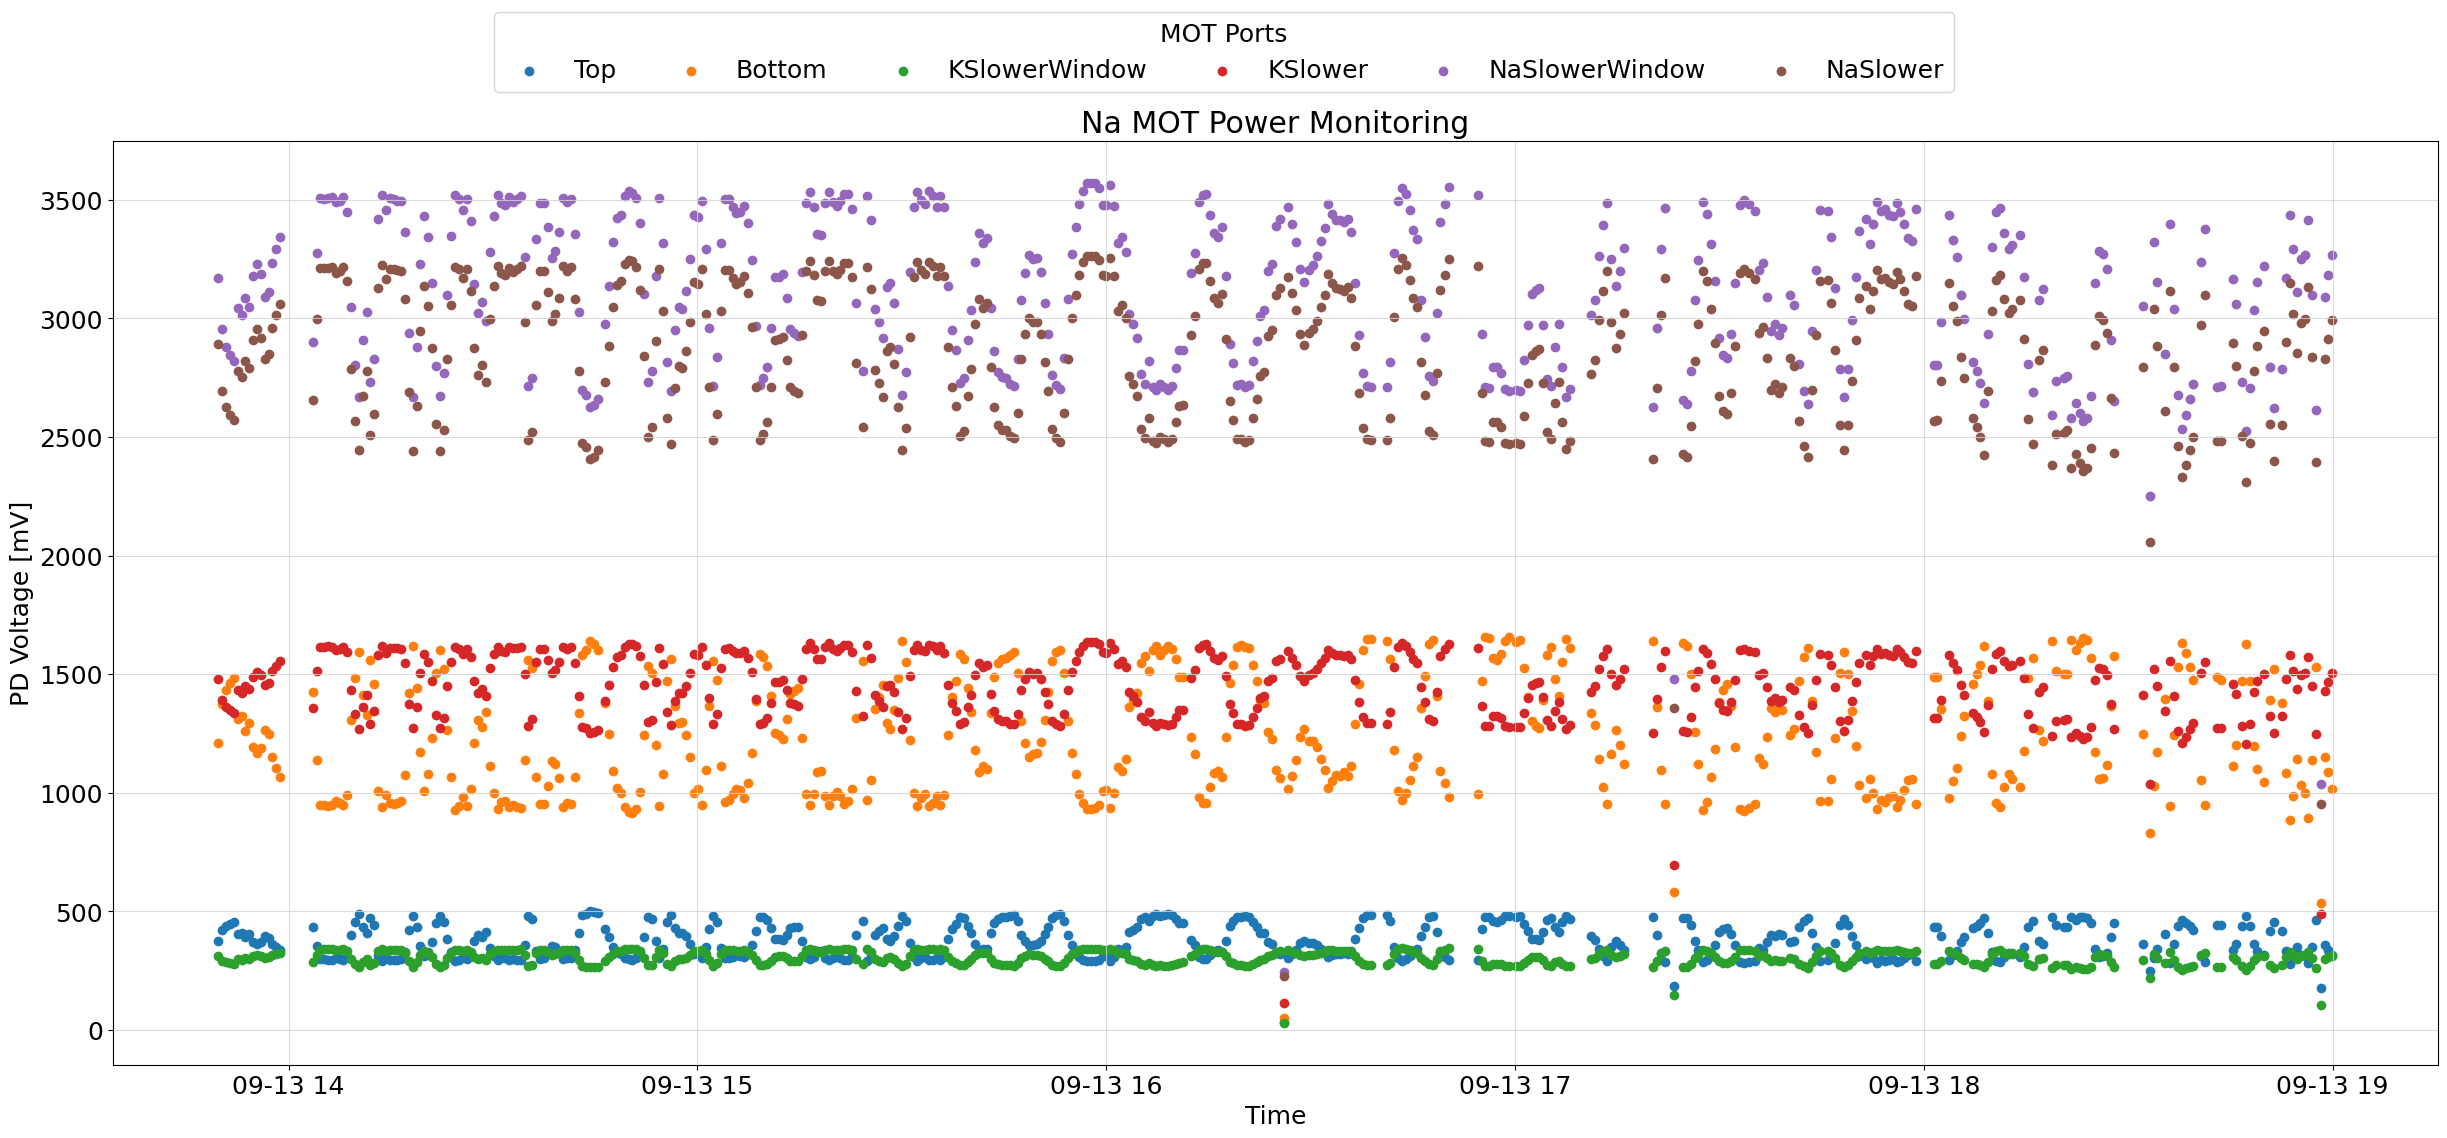

In [17]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(30,12))
for port in NaMOT_ports:
    label = port.split('_')[1]
    ax.scatter(df['datetimes'],df[port],label=label)

ax.set_xlabel('Time')
ax.set_ylabel('PD Voltage [mV]')
ax.set_title('Na MOT Power Monitoring')
fig.legend(loc='upper center', ncol = 7, title='MOT Ports')
ax.grid(color='lightgray', alpha=0.8)

# mpld3.display()

In [9]:
startlogging_idx = df['NaMOT_Top_mean_in_mv'].index.get_loc(df['NaMOT_Top_mean_in_mv'].first_valid_index())
startlogging_idx

172

In [10]:
df['NaMOT_Top_mean_in_mv'].iloc[startlogging_idx]

374.41934385204627

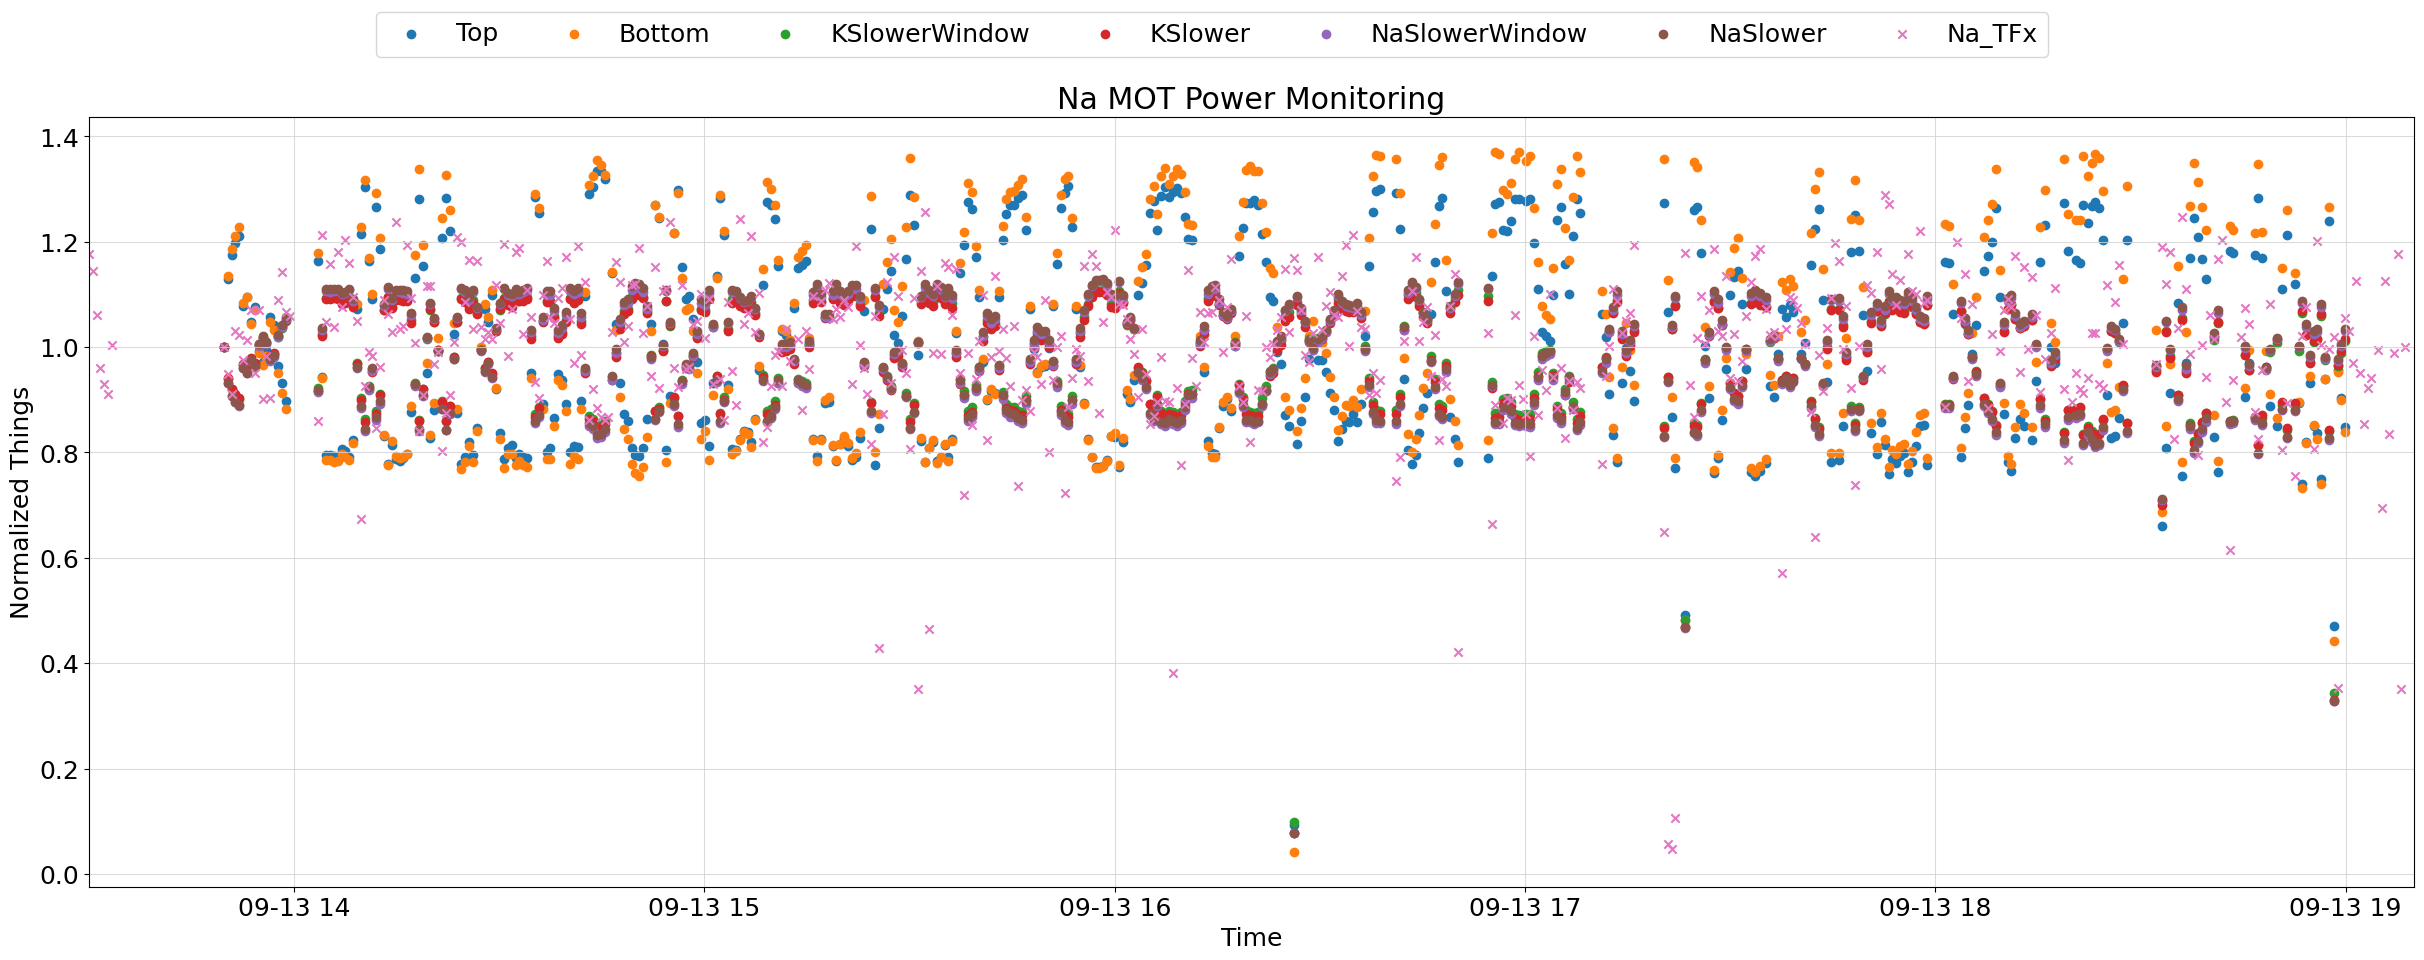

In [18]:
fig, ax = plt.subplots(figsize=(30,10))
for port in NaMOT_ports:
    label = port.split('_')[1]
    start_value = df[port].iloc[startlogging_idx]
    ax.scatter(df['datetimes'],df[port]/start_value,label=label)
ax.scatter(df['datetimes'], df['Na_TFx']/df['Na_TFx'].iloc[startlogging_idx], label='Na_TFx',marker='x')

ax.set_xlim([datetime(2022,9,13,13,30), datetime(2022,9,13,19,10)])

ax.set_xlabel('Time')
ax.set_ylabel('Normalized Things')
ax.set_title('Na MOT Power Monitoring')
fig.legend(loc='upper center', ncol = 7,)
ax.grid(color='lightgray', alpha=0.8)

# mpld3.display(fig)

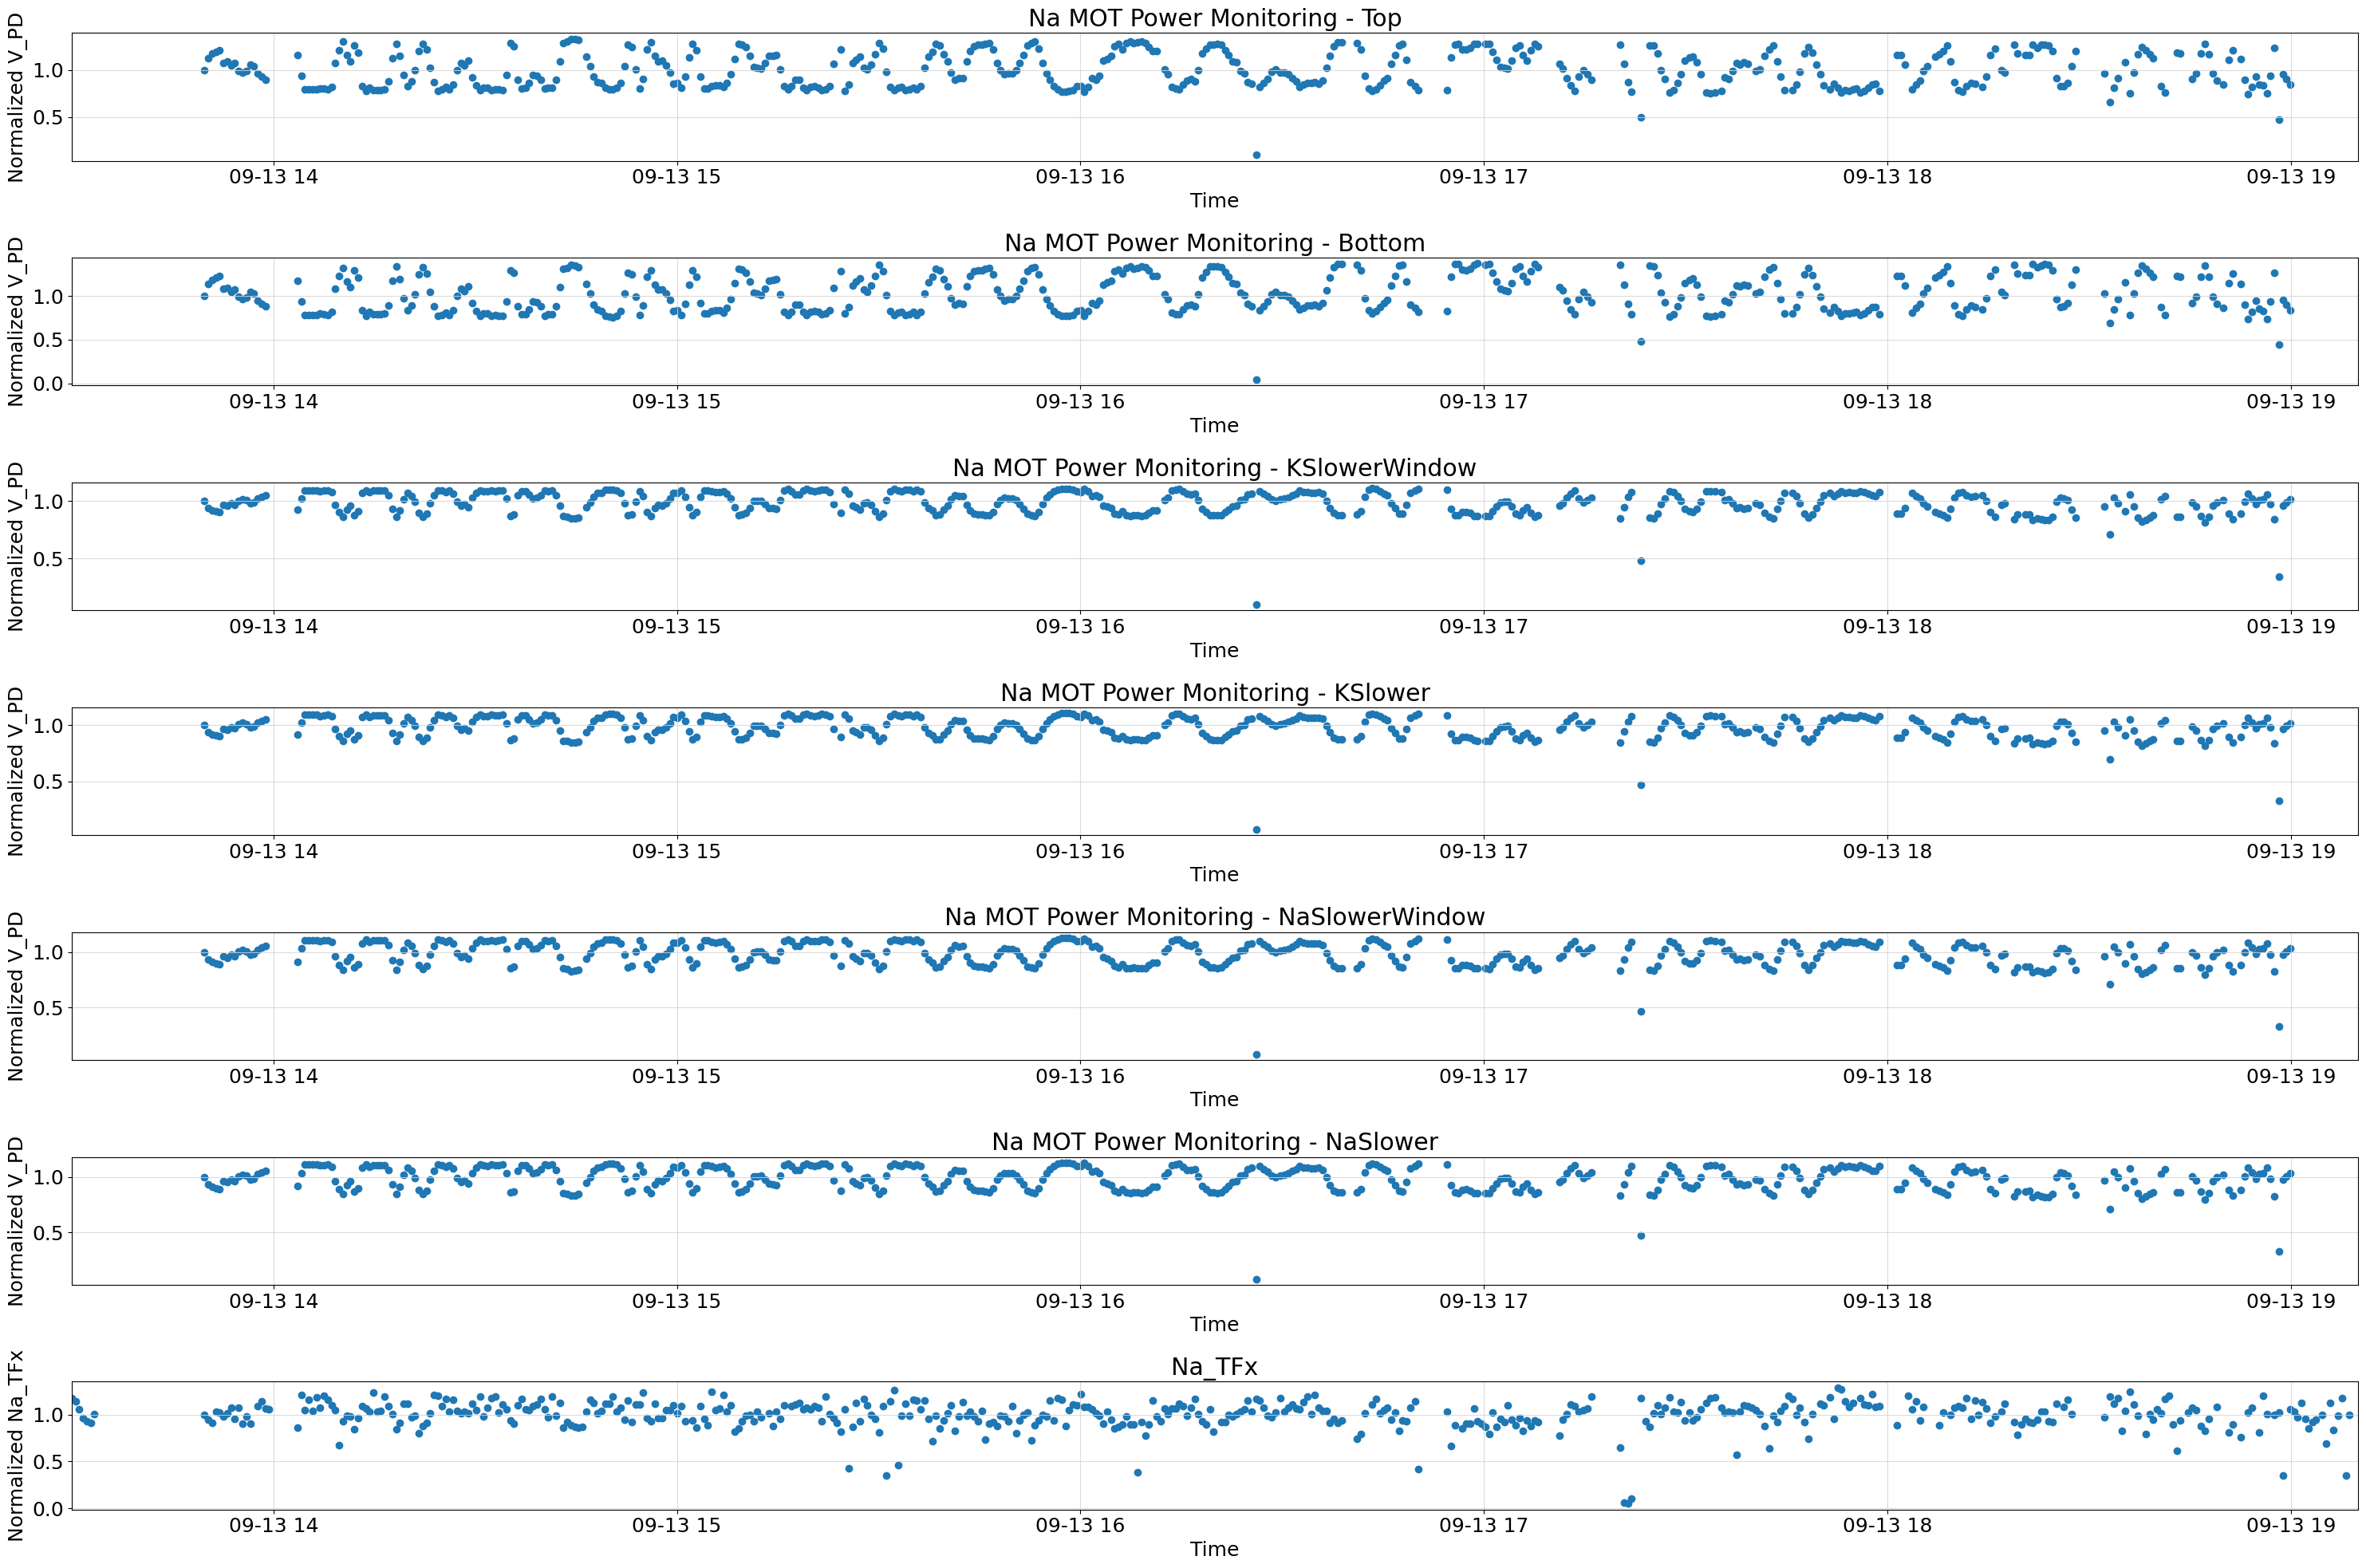

In [19]:
fig, axes = plt.subplots(7,1,sharex=True,figsize=(30,20))
for port, ax in zip(NaMOT_ports, axes[:-1]):
    label = port.split('_')[1]
    start_value = df[port].iloc[startlogging_idx]
    ax.scatter(df['datetimes'],df[port]/start_value,label=label)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.grid(color='lightgray', alpha=0.8)
    ax.set_xlabel('Time')
    ax.set_ylabel('Normalized V_PD')
    ax.set_title(f'Na MOT Power Monitoring - {label}')


axes[-1].scatter(df['datetimes'], df['Na_TFx']/df['Na_TFx'].iloc[startlogging_idx], label='Na_TFx')
axes[-1].grid(color='lightgray', alpha=0.8)
axes[-1].set_xlabel('Time')
axes[-1].set_ylabel('Normalized Na_TFx')
axes[-1].set_title('Na_TFx')

axes[0].set_xlim([datetime(2022,9,13,13,30), datetime(2022,9,13,19,10)])

plt.tight_layout()


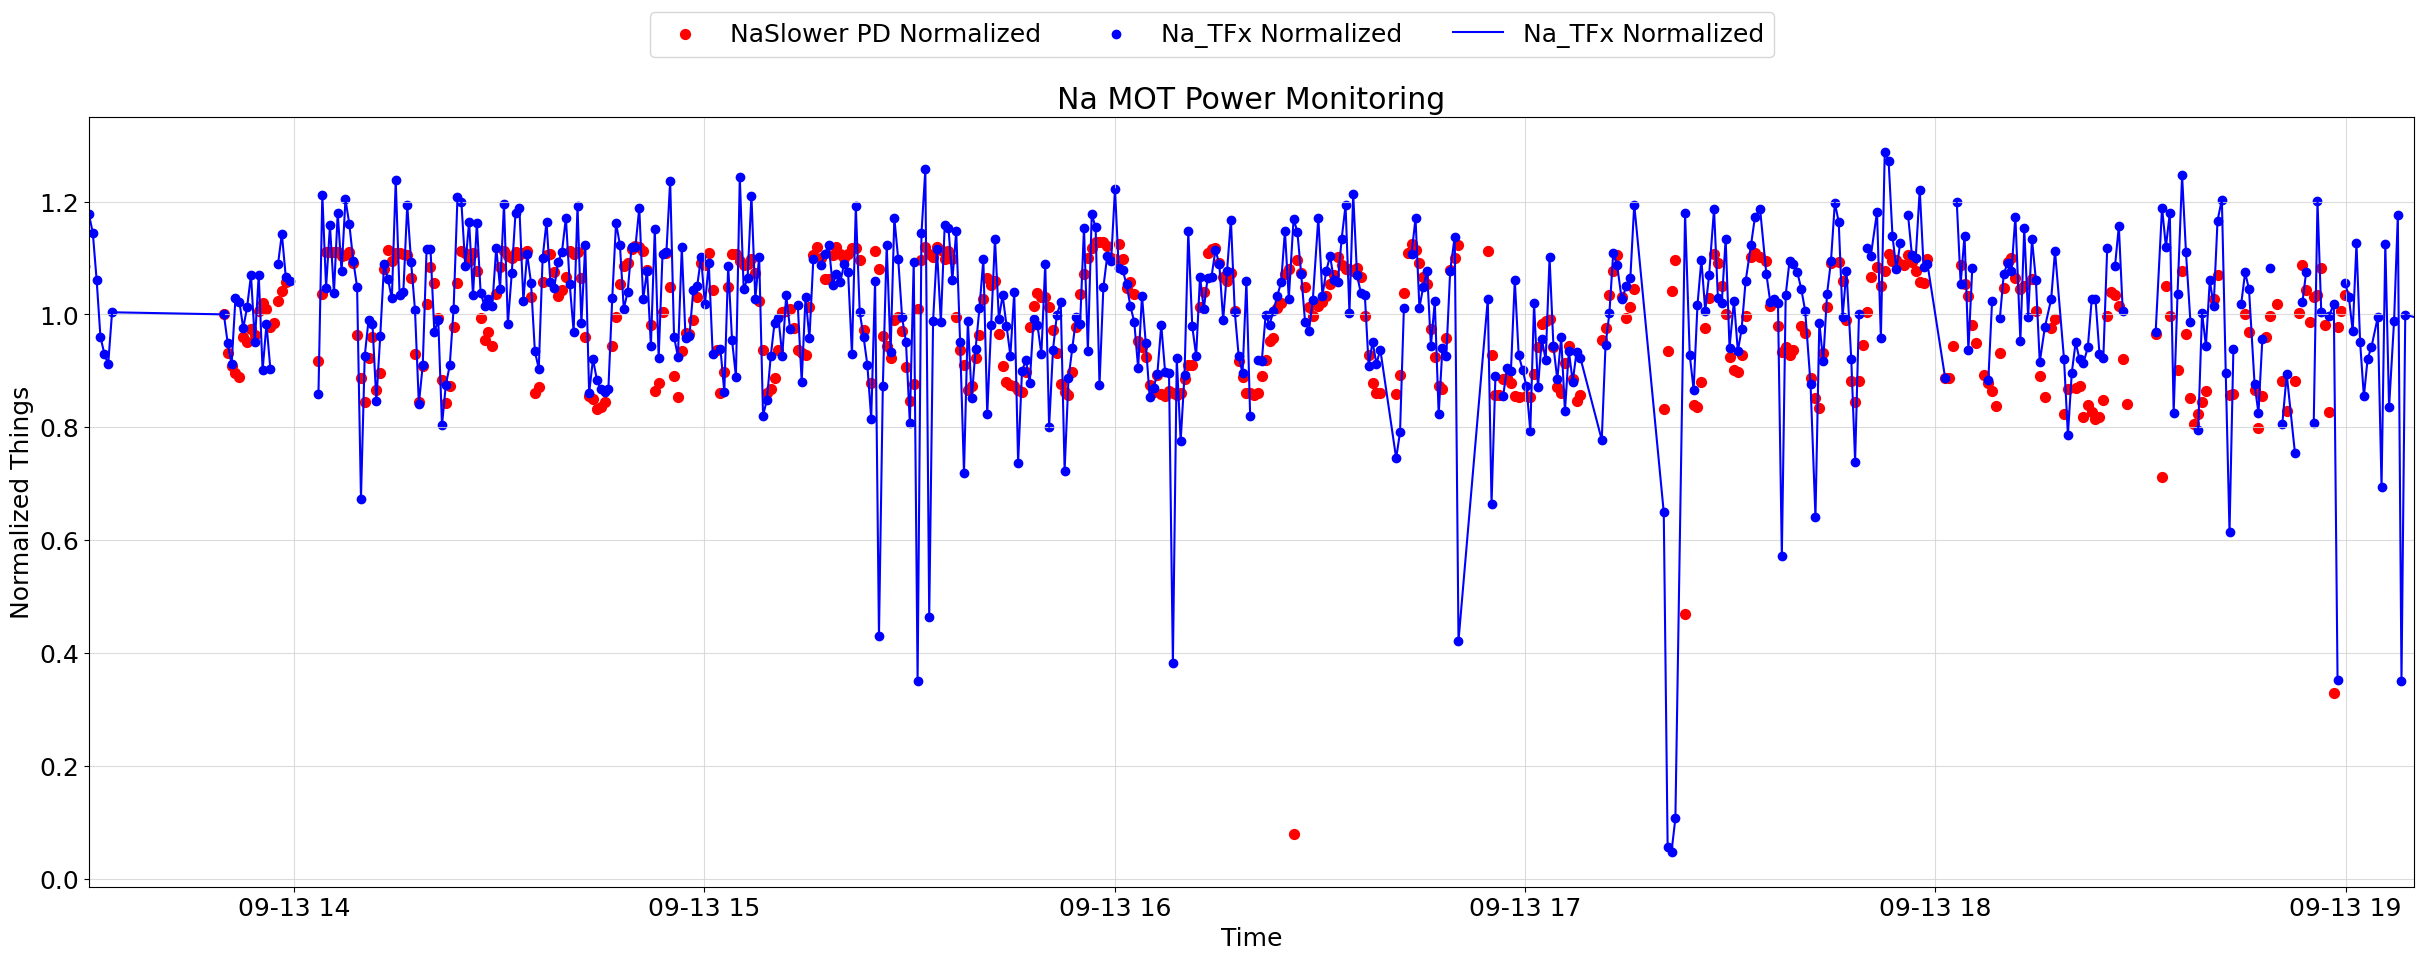

In [20]:
fig, ax = plt.subplots(figsize=(30,10))
ax.scatter(df['datetimes'], df['NaMOT_NaSlower_mean_in_mv']/df['NaMOT_NaSlower_mean_in_mv'].iloc[startlogging_idx], 
            label='NaSlower PD Normalized',
            color='red',
            s=50
            )
ax.scatter(df['datetimes'], df['Na_TFx']/df['Na_TFx'].iloc[startlogging_idx], label='Na_TFx Normalized',color='blue')
ax.plot(df['datetimes'], df['Na_TFx']/df['Na_TFx'].iloc[startlogging_idx], label='Na_TFx Normalized',color='blue')

ax.set_xlim([datetime(2022,9,13,13,30), datetime(2022,9,13,19,10)])

ax.set_xlabel('Time')
ax.set_ylabel('Normalized Things')
ax.set_title('Na MOT Power Monitoring')
fig.legend(loc='upper center', ncol = 3)
ax.grid(color='lightgray', alpha=0.8)

# mpld3.display(fig)

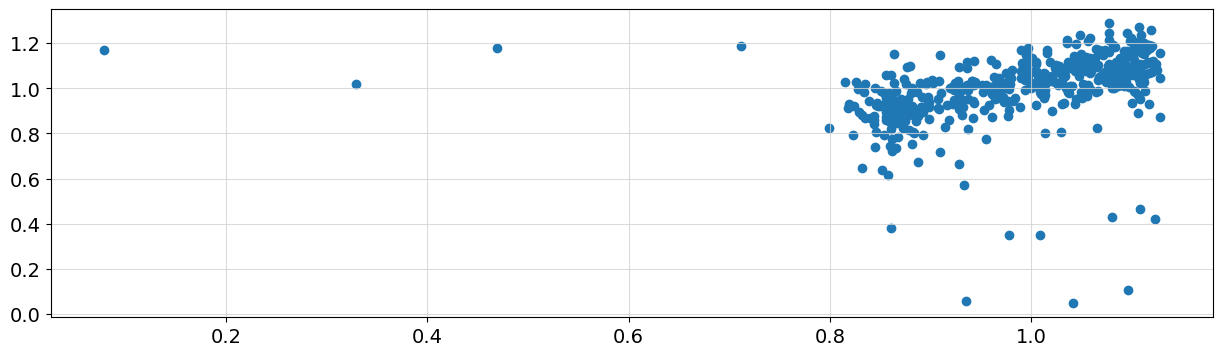

In [29]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15,4))
ax.scatter(df['NaMOT_NaSlower_mean_in_mv']/df['NaMOT_NaSlower_mean_in_mv'].iloc[startlogging_idx],
            df['Na_TFx']/df['Na_TFx'].iloc[startlogging_idx])
ax.grid(color='lightgray', alpha=0.8)

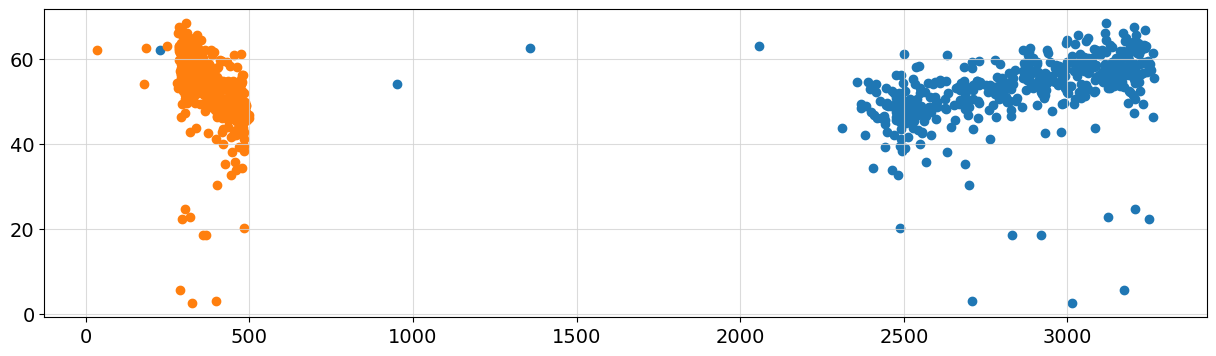

In [34]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(15,4))
ax.scatter(df['NaMOT_NaSlower_mean_in_mv'],
            df['Na_TFx'])
ax.scatter(df['NaMOT_Top_mean_in_mv'],
df['Na_TFx'])
ax.grid(color='lightgray', alpha=0.8)

In [60]:
corrmat = df[['Na_TFx'] + NaMOT_ports].corr().round(5)
corrmat.columns = (['Na_TFx']+[port.split('_')[1] for port in NaMOT_ports])
corrmat.index = (['Na_TFx']+[port.split('_')[1] for port in NaMOT_ports])

<AxesSubplot:>

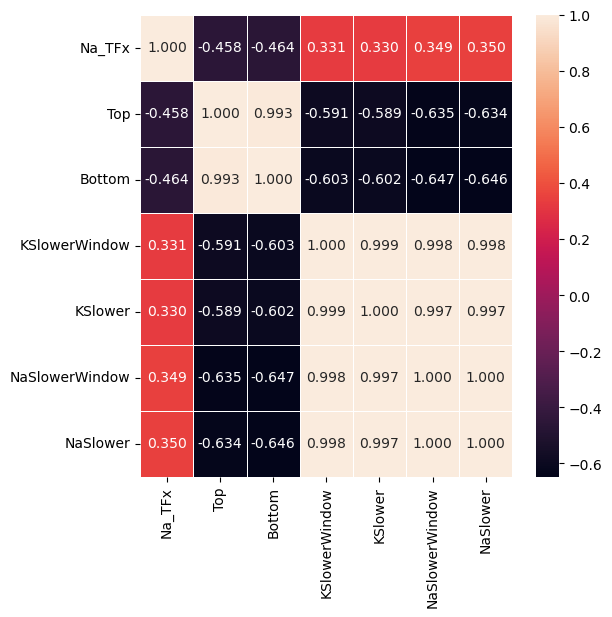

In [71]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corrmat, annot=True, fmt='.3f',linewidths=0.5, ax=ax)